In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gsp
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
import sklearn.metrics as mtc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import xgboost as xgb
import functions as fn
import warnings
warnings.filterwarnings('ignore')

import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

df = pd.read_csv('bbc-text.csv')
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


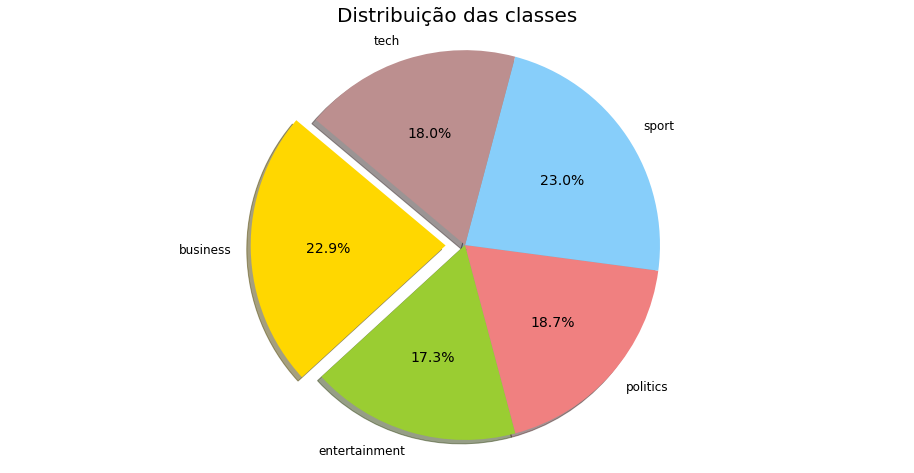

In [289]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
plt.title('Distribuição das classes', fontsize=20)
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'rosybrown']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice
count = df.pivot_table(values='text',index=['category'], aggfunc='count').reset_index()
plt.pie(count.text, labels=count.category, autopct='%1.1f%%', explode=explode, colors=colors, shadow=True, startangle=140)
plt.rc('xtick', labelsize=12) 
plt.axis('equal')
plt.savefig('pizza.png')
plt.show();

In [3]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

In [4]:
df.iloc[2,1]

'tigers wary of farrell  gamble  leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes.   we and anybody else involved in the process are still some way away from going to the next stage   tigers boss john wells told bbc radio leicester.  at the moment  there are still a lot of unknowns about andy farrell  not least his medical situation.  whoever does take him on is going to take a big  big gamble.  farrell  who has had persistent knee problems  had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game.  if he does move across to union  wells believes he would better off playing in the backs  at least initially.  i m sure he could make the step between league and union by being involved in the centre   said wells.  i t

In [5]:
fn.clean_text(df.iloc[2,1], filters)

'tiger wari farrel gambl leicest rush make bid andi farrel great britain rugbi leagu captain decid switch code anybodi involv process wai awai go stage tiger boss john well told bbc radio leicest moment lot unknown andi farrel medic situat go big big gambl farrel persist knee problem oper knee week ago expect month leicest saracen believ head list rugbi union club interest sign farrel decid man game union well believ better plai back initi sure step leagu union involv centr said well think england prefer progress posit row us rugbi leagu skill forward juri cross divid club balanc struck cost gambl option bring readi replac'

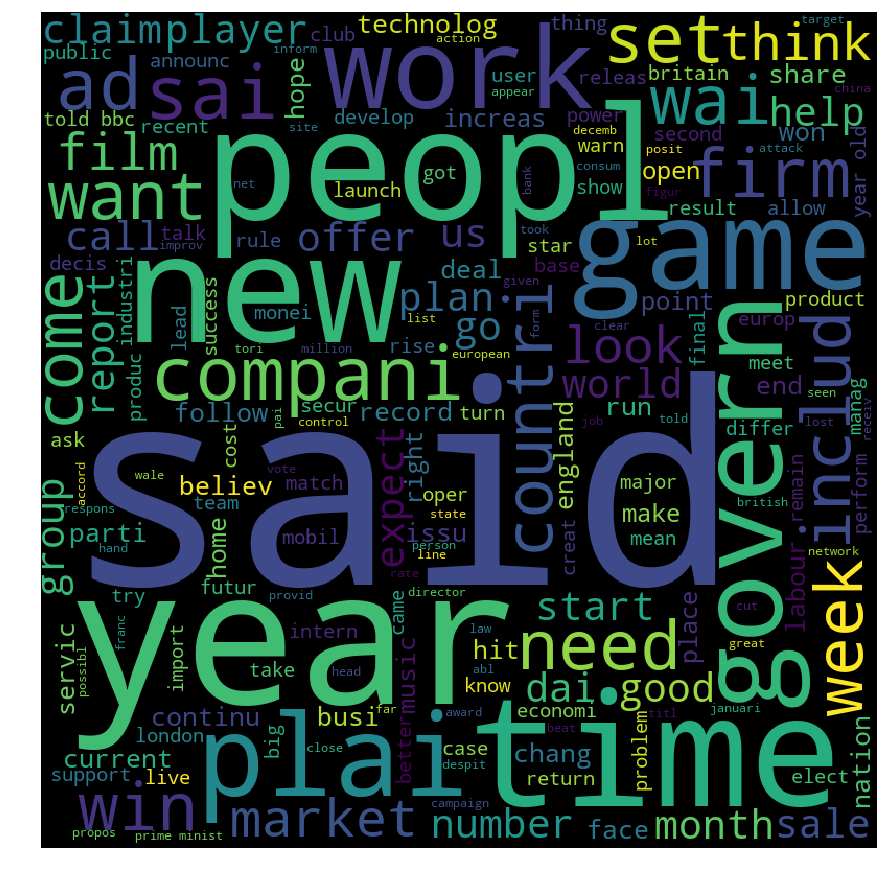

In [304]:
fn.plot_word_cloud(df,filters, file_name='cloud_total')

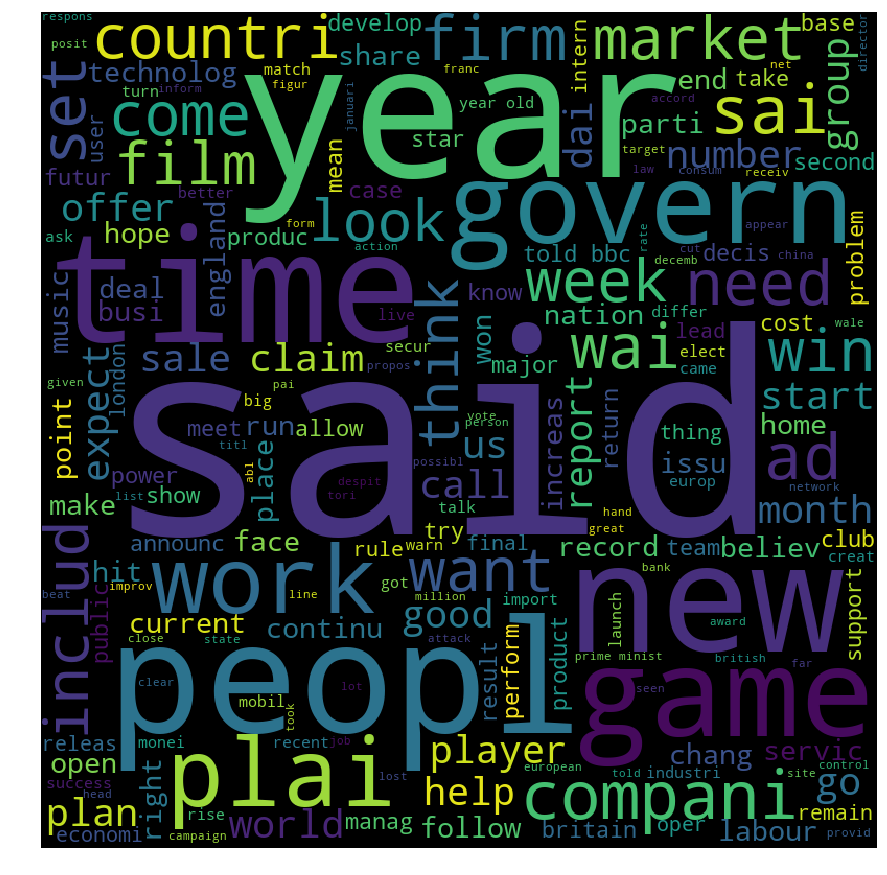

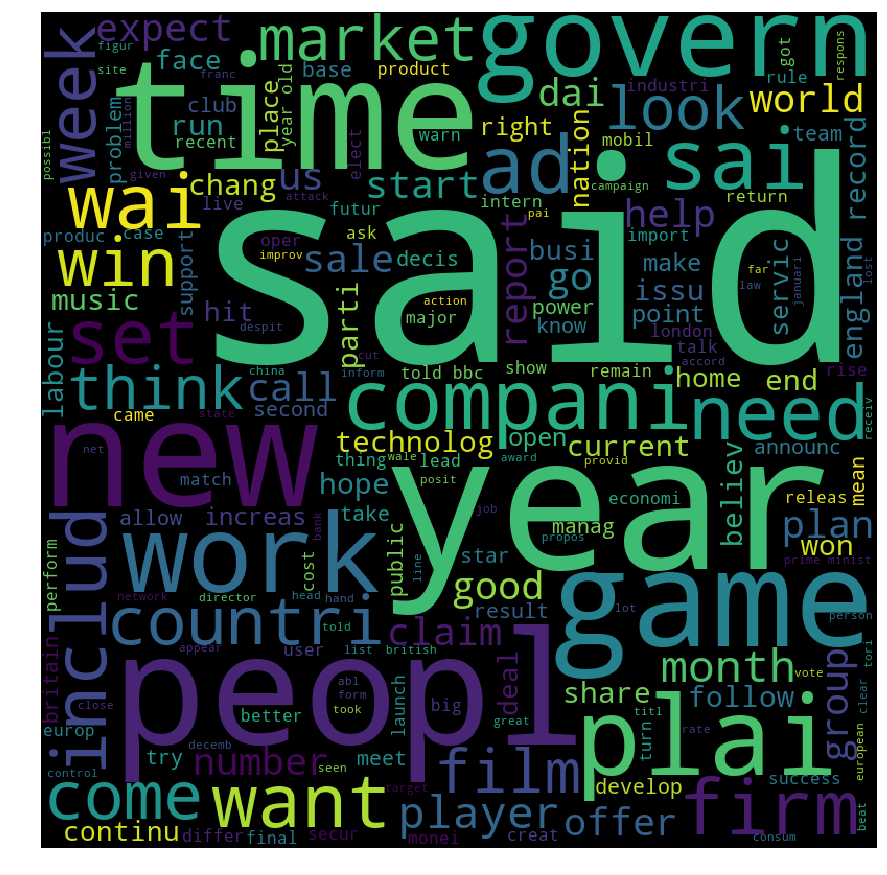

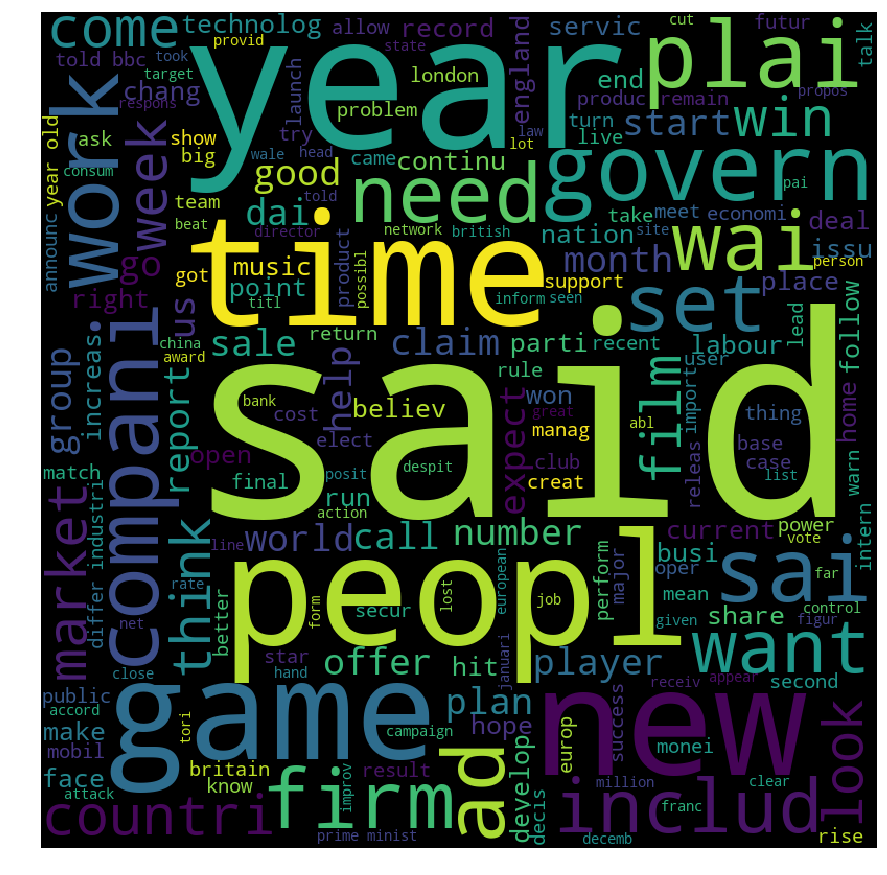

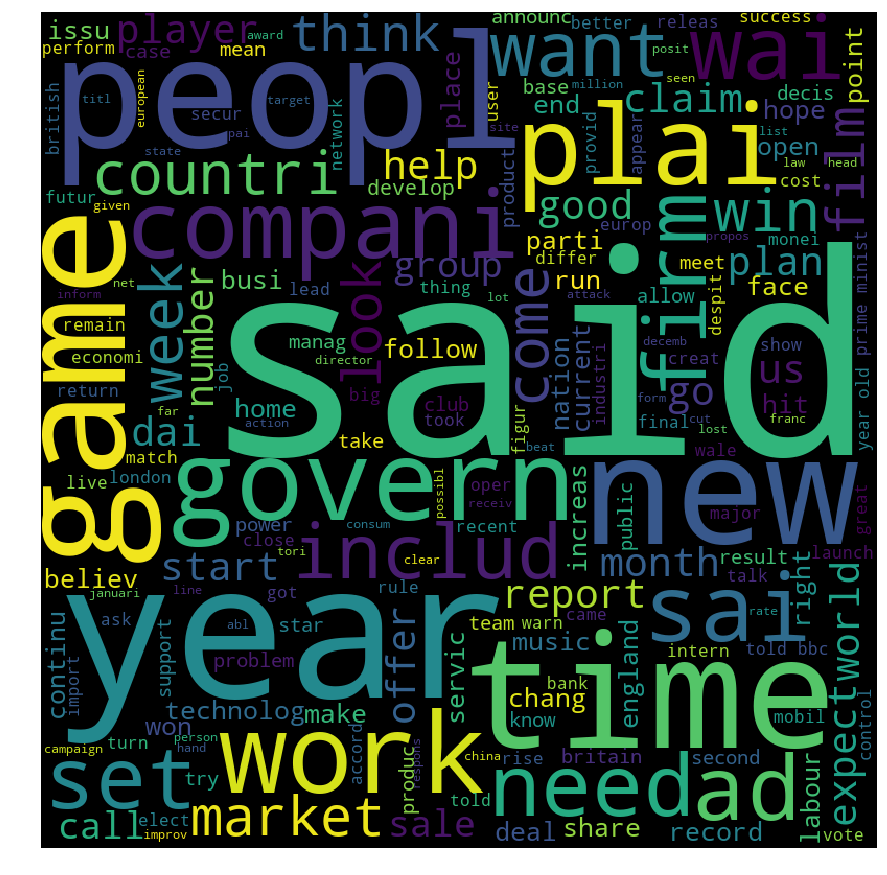

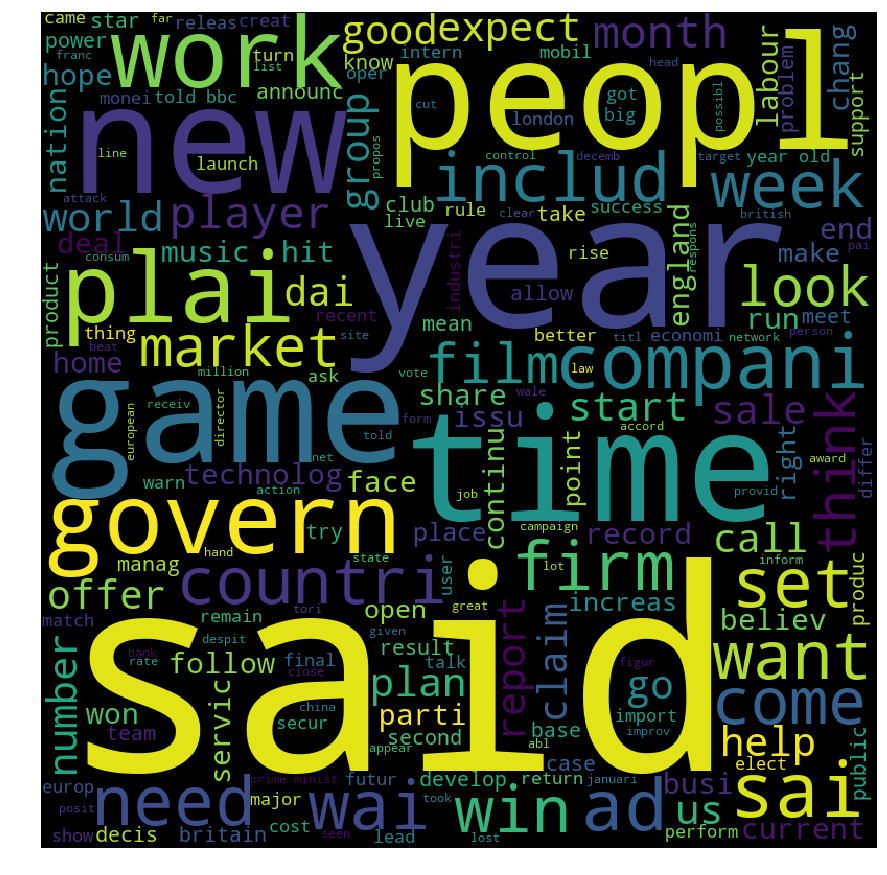

In [305]:
for cat in df.category.unique():
    fn.plot_word_cloud(df,filters, file_name=str('cloud_' + cat))

In [7]:
df_x = df.text
df_y = df.category
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1)
doc2vec_trf = fn.Doc2VecTransformer(filters)
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 2225/2225 [00:00<00:00, 1285267.37it/s]


matrix([[ 0.02209522,  0.08439775, -0.08823411, ..., -0.04603997,
         -0.02332608,  0.01440045],
        [ 0.03686959,  0.07156537, -0.10846121, ..., -0.05692741,
         -0.04198892,  0.01892374],
        [ 0.05654714,  0.0960089 , -0.12725247, ..., -0.0884491 ,
         -0.07112904,  0.01769536],
        ...,
        [ 0.0750534 ,  0.1715312 , -0.24872082, ..., -0.09801845,
         -0.07425075,  0.04769209],
        [ 0.22561926,  0.34880227, -0.5802927 , ..., -0.43206432,
         -0.3814234 ,  0.03237136],
        [ 0.00069436, -0.00521553,  0.00702554, ...,  0.001818  ,
         -0.00380272,  0.00395418]], dtype=float32)

In [8]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
    'classifier__C' : np.logspace(-6, 6, 20),
    'classifier__solver' : ['liblinear','saga', 'lbfgs'],
    'classifier__multi_class': ['multinomial'],
    'classifier__max_iter': [100, 200]}]


pl_log_reg = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('classifier', LogisticRegression())])

clf = RandomizedSearchCV(pl_log_reg, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
#scores_lr = cross_val_score(pl_log_reg, df_x, df_y, cv=5, scoring='accuracy')
#print('Accuracy for Logistic Regression: ', scores_lr.mean())
best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 42

In [9]:
best_clf.best_params_['classifier']

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [10]:
pl_log_reg_test = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('log_reg', best_clf.best_params_['classifier'])])
clf_lr = pl_log_reg_test.fit(X_train, y_train)
print('Accuracy for Logistic Regression: ', clf_lr.score(X_test,y_test))

100%|██████████| 1780/1780 [00:00<00:00, 1240382.31it/s]


Accuracy for Logistic Regression:  0.4314606741573034


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'classifier' : [RandomForestClassifier()],
               'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
pl_random_forest = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                                   ('classifier', RandomForestClassifier())])

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(pl_random_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 58

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('doc2vec',
                                              Doc2VecTransformer(epochs=20,
                                                                 filters=[<function strip_tags at 0x1a1e1008c0>,
                                                                          <function strip_punctuation at 0x1a1e10dd40>,
                                                                          <function strip_multiple_whitespaces at 0x1a1e1035f0>,
                                                                          <function strip_numeric at 0x1a1e100f80>,
                                                                          <function remove_stopwords at 0x1a1e0ef050>,
                                                                          <function strip_s...
                                        'classifier__max_depth': [10, 20, 30,
    

In [12]:
rf_random.best_params_

{'classifier__n_estimators': 1000,
 'classifier__min_samples_split': 5,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 20,
 'classifier__bootstrap': True,
 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=20, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=5,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)}

In [13]:
pl_rf_test = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('random_forest', rf_random.best_params_['classifier'])])
clf_rf = pl_rf_test.fit(X_train, y_train)
print('Accuracy for Random Forest: ', clf_rf.score(X_test,y_test))

100%|██████████| 1780/1780 [00:00<00:00, 1978235.59it/s]


Accuracy for Random Forest:  0.39325842696629215


In [36]:
param_grid = [
    {'classifier' : [SVC()],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__kernel' : ['rbf','poly', 'sigmoid'],
     'classifier__degree' : [3, 4, 5],
     'classifier__gamma' : ['scale', 'auto'],
     'classifier__coef0': np.linspace(-2, 2, 10),
     'classifier__max_iter': [100, 200],
     'classifier__probability': [True],
     'classifier__decision_function_shape': ['ovo']}]

pl_SVC = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                         ('classifier', SVC())])

clf_svc = RandomizedSearchCV(pl_SVC, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_svc = clf_svc.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 54

In [37]:
pl_svc_test = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('SVC', best_clf_svc.best_params_['classifier'])])
clf_svc = pl_svc_test.fit(X_train, y_train)
print('Accuracy for SVC: ', clf_svc.score(X_test,y_test))

100%|██████████| 1780/1780 [00:00<00:00, 1684155.45it/s]


Accuracy for SVC:  0.21123595505617979


In [16]:
param_grid = [
    {'classifier' : [MLPClassifier()],
     'classifier__hidden_layer_sizes' : [2, 16, 64, 128, 512],
     'classifier__activation' : ['logistic','tanh', 'relu'],
     'classifier__solver' : ['lbfgs', 'sgd', 'adam'],
     'classifier__alpha' : [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
     'classifier__batch_size' : [30, 50, 100, 'auto'],
     'classifier__learning_rate': ['constant', 'invsclaing', 'adaptive'],
     'classifier__max_iter': [100, 200]}]

pl_mlp = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                         ('classifier', MLPClassifier())])

clf_mlp = RandomizedSearchCV(pl_mlp, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_mlp = clf_mlp.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 47

In [17]:
pl_mlp_test = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('MLP', best_clf_mlp.best_params_['classifier'])])
clf_mlp = pl_mlp_test.fit(X_train, y_train)
print('Accuracy for MLP: ', clf_mlp.score(X_test,y_test))

100%|██████████| 1780/1780 [00:00<00:00, 1273168.68it/s]


Accuracy for MLP:  0.3752808988764045


In [18]:
param_grid = [
    {'classifier' : [xgb.XGBClassifier()],
     'classifier__booster' : ['gbtree', 'gblinear', 'dart'],
     'classifier__objective' : ['multi:softmax','multi:softprob'],
     'classifier__eta' : [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
     'classifier__gamma' : [0, 2, 4, 6],
     'classifier__max_depth' : [4, 6, 10, 20],
     'classifier__min_child_weight' : [1, 3, 5],
     'classifier__max_delta_step': [0, 1, 10],
     'classifier__lambda': [1, 10, 100],
     'classifier__alpha': [0, 10, 100]}]


pl_xgb = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                         ('classifier', xgb.XGBClassifier())])

clf_xgb = RandomizedSearchCV(pl_xgb, param_distributions = param_grid, n_iter = 300, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_xgb = clf_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 49.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 56.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 64

In [19]:
pl_xgb_test = Pipeline(steps=[('doc2vec',fn.Doc2VecTransformer(filters)),
                             ('XGB', best_clf_xgb.best_params_['classifier'])])
clf_xgb = pl_xgb_test.fit(X_train, y_train)
print('Accuracy for XGB: ', clf_xgb.score(X_test,y_test))

100%|██████████| 1780/1780 [00:00<00:00, 1667976.12it/s]


Accuracy for XGB:  0.4


In [20]:
tfidf_transformer = fn.Text2TfIdfTransformer(filters)
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [21]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
    'classifier__C' : np.logspace(-6, 6, 20),
    'classifier__solver' : ['liblinear','saga', 'lbfgs'],
    'classifier__multi_class': ['multinomial'],
    'classifier__max_iter': [100, 200]}]


pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('classifier', LogisticRegression())])

clf_tf_idf = RandomizedSearchCV(pl_log_reg_tf_idf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
#scores_lr = cross_val_score(pl_log_reg, df_x, df_y, cv=5, scoring='accuracy')
#print('Accuracy for Logistic Regression: ', scores_lr.mean())
best_clf_tf_idf = clf_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

In [22]:
pl_log_reg_tf_idf_test = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('log_reg', best_clf_tf_idf.best_params_['classifier'])])
clf_lr_tf_idf = pl_log_reg_tf_idf_test.fit(X_train, y_train)
print('Accuracy for Logistic Regression: ', clf_lr_tf_idf.score(X_test,y_test))

Accuracy for Logistic Regression:  0.9662921348314607


In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'classifier' : [RandomForestClassifier()],
               'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                                   ('classifier', RandomForestClassifier())])

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_tf_idf = RandomizedSearchCV(pl_random_forest_tf_idf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_tf_idf.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 19

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidf',
                                              Text2TfIdfTransformer(filters=[<function strip_tags at 0x1a1e1008c0>,
                                                                             <function strip_punctuation at 0x1a1e10dd40>,
                                                                             <function strip_multiple_whitespaces at 0x1a1e1035f0>,
                                                                             <function strip_numeric at 0x1a1e100f80>,
                                                                             <function remove_stopwords at 0x1a1e0ef050>,
                                                                             <function strip_short at 0x1...
                                        'classifier__max_depth': [10, 20, 30,
                                                     

In [24]:
pl_rf_tf_idf_test = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('random_forest', rf_random_tf_idf.best_params_['classifier'])])
clf_rf_tf_idf = pl_rf_tf_idf_test.fit(X_train, y_train)
print('Accuracy for Random Forest: ', clf_rf_tf_idf.score(X_test,y_test))

Accuracy for Random Forest:  0.9550561797752809


In [38]:
param_grid = [
    {'classifier' : [SVC()],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__kernel' : ['rbf','poly', 'sigmoid'],
     'classifier__degree' : [3, 4, 5],
     'classifier__gamma' : ['scale', 'auto'],
     'classifier__coef0': np.linspace(-2, 2, 10),
     'classifier__max_iter': [100, 200],
     'classifier__probability': [True],
     'classifier__decision_function_shape': ['ovo']}]

pl_SVC_tf_idf = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                         ('classifier', SVC())])

clf_svc_tf_idf = RandomizedSearchCV(pl_SVC_tf_idf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_svc_tf_idf = clf_svc_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 16

In [39]:
pl_svc_tf_idf_test = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('SVC', best_clf_svc_tf_idf.best_params_['classifier'])])
clf_svc_tf_idf = pl_svc_tf_idf_test.fit(X_train, y_train)
print('Accuracy for SVC: ', clf_svc_tf_idf.score(X_test,y_test))

Accuracy for SVC:  0.9550561797752809


In [27]:
param_grid = [
    {'classifier' : [MLPClassifier()],
     'classifier__hidden_layer_sizes' : [2, 16, 64, 128, 512],
     'classifier__activation' : ['logistic','tanh', 'relu'],
     'classifier__solver' : ['lbfgs', 'sgd', 'adam'],
     'classifier__alpha' : [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
     'classifier__batch_size' : [30, 50, 100, 'auto'],
     'classifier__learning_rate': ['constant', 'invsclaing', 'adaptive'],
     'classifier__max_iter': [100, 200]}]

pl_mlp_tf_idf = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                         ('classifier', MLPClassifier())])

clf_mlp_tf_idf = RandomizedSearchCV(pl_mlp_tf_idf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_mlp_tf_idf = clf_mlp_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 63.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 83.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 89.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 97.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 13

In [28]:
pl_mlp_tf_idf_test = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('MLP', best_clf_mlp_tf_idf.best_params_['classifier'])])
clf_mlp_tf_idf = pl_mlp_tf_idf_test.fit(X_train, y_train)
print('Accuracy for MLP: ', clf_mlp_tf_idf.score(X_test,y_test))

Accuracy for MLP:  0.9797752808988764


In [29]:
param_grid = [
    {'classifier' : [xgb.XGBClassifier()],
     'classifier__booster' : ['gbtree', 'gblinear', 'dart'],
     'classifier__objective' : ['multi:softmax','multi:softprob'],
     'classifier__eta' : [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
     'classifier__gamma' : [0, 2, 4, 6],
     'classifier__max_depth' : [4, 6, 10, 20],
     'classifier__min_child_weight' : [1, 3, 5],
     'classifier__max_delta_step': [0, 1, 10],
     'classifier__lambda': [1, 10, 100],
     'classifier__alpha': [0, 10, 100]}]


pl_xgb_tf_idf = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                         ('classifier', xgb.XGBClassifier())])

clf_xgb_tf_idf = RandomizedSearchCV(pl_xgb_tf_idf, param_distributions = param_grid, n_iter = 300, cv = 3, verbose=10, random_state=42, n_jobs=-1)
best_clf_xgb_tf_idf = clf_xgb_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 67

In [30]:
pl_xgb_tf_idf_test = Pipeline(steps=[('tfidf',fn.Text2TfIdfTransformer(filters)),
                             ('XGB', best_clf_xgb_tf_idf.best_params_['classifier'])])
clf_xgb_tf_idf = pl_xgb_tf_idf_test.fit(X_train, y_train)
print('Accuracy for XGB: ', clf_xgb_tf_idf.score(X_test,y_test))

Accuracy for XGB:  0.9483146067415731


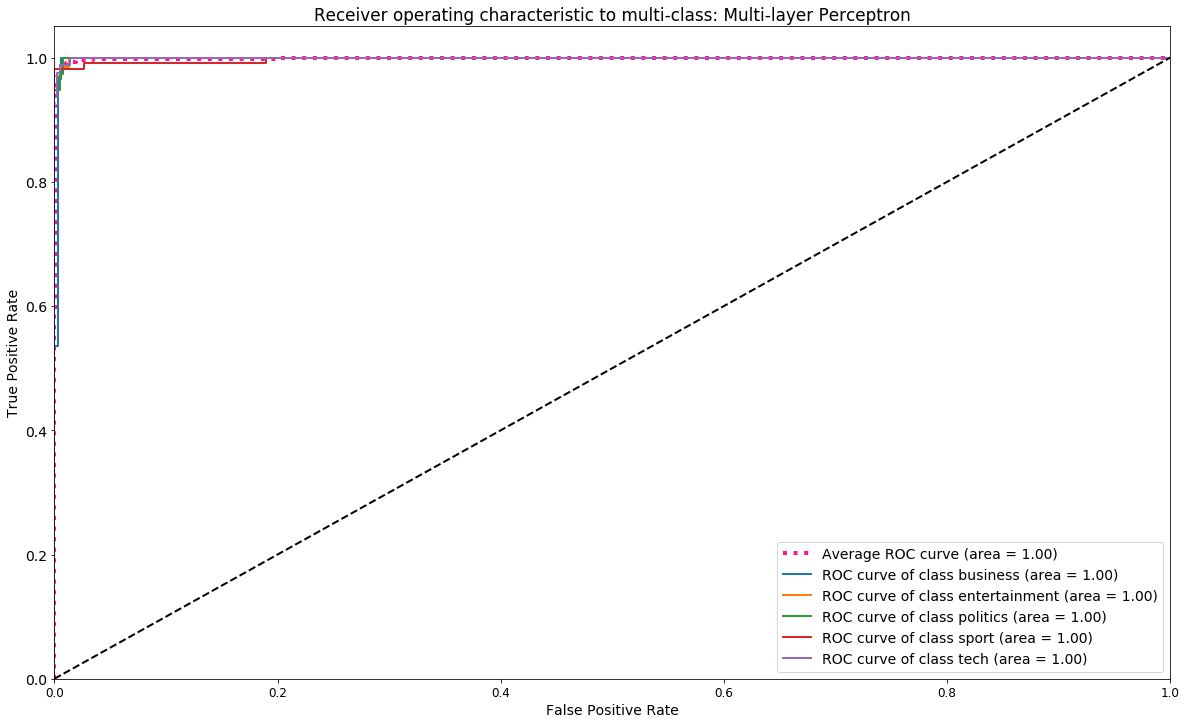

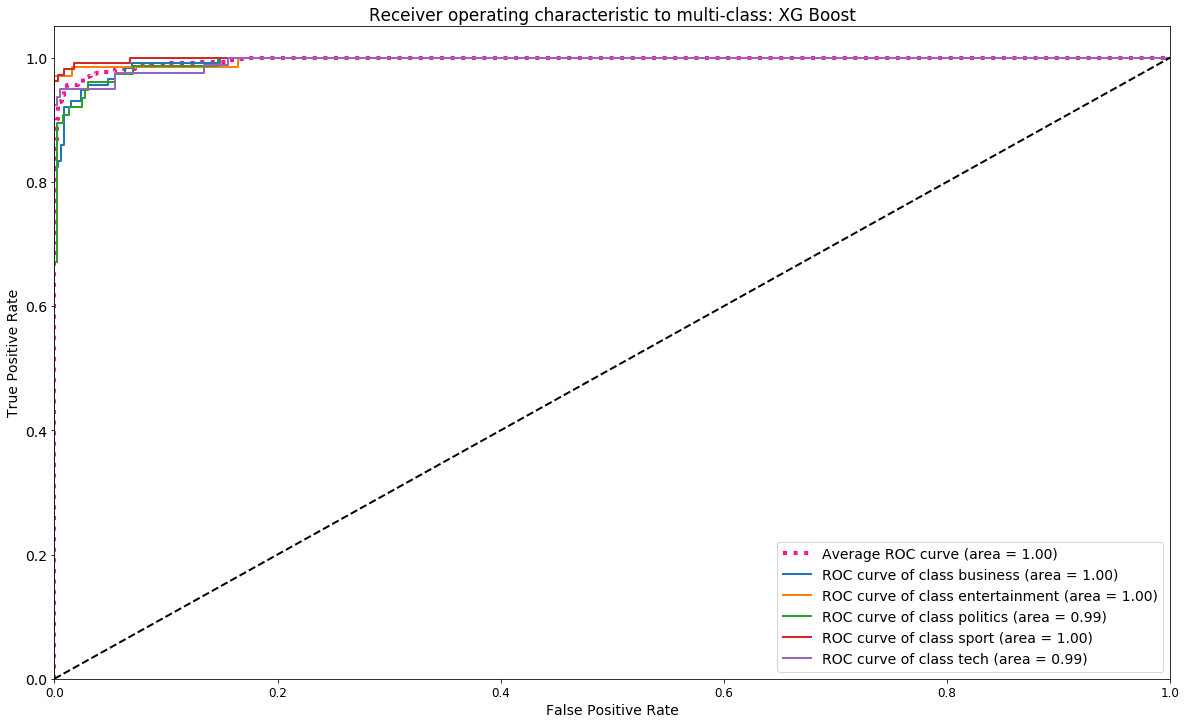

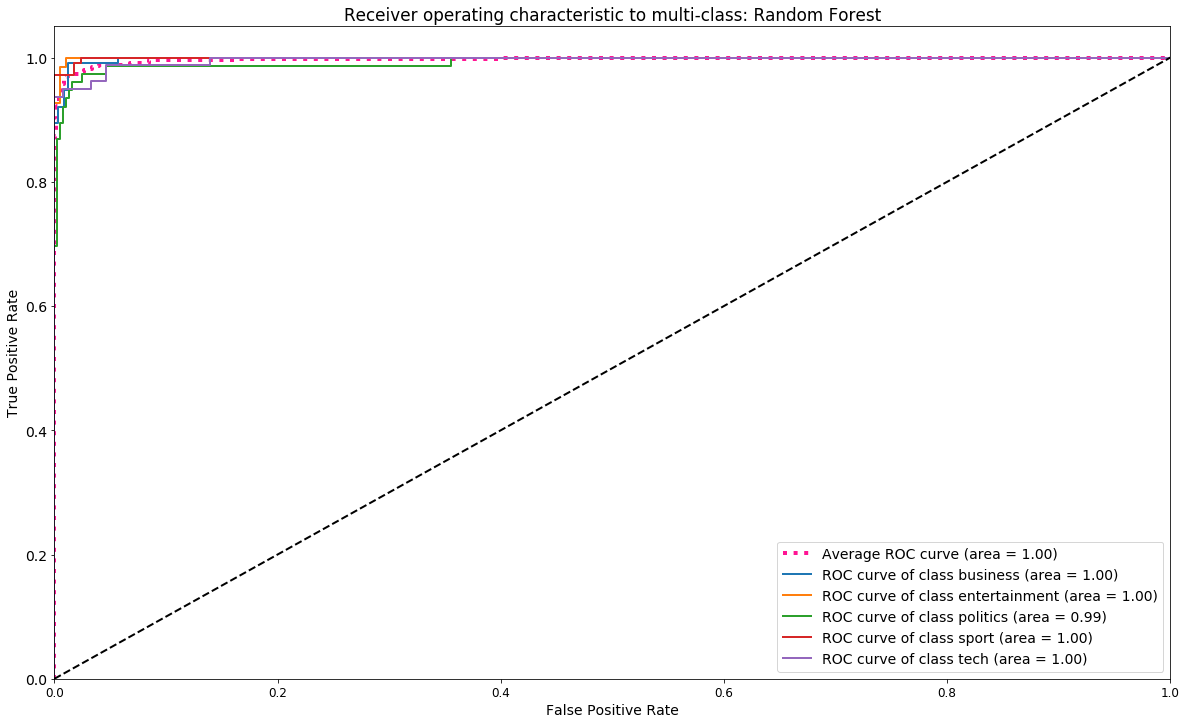

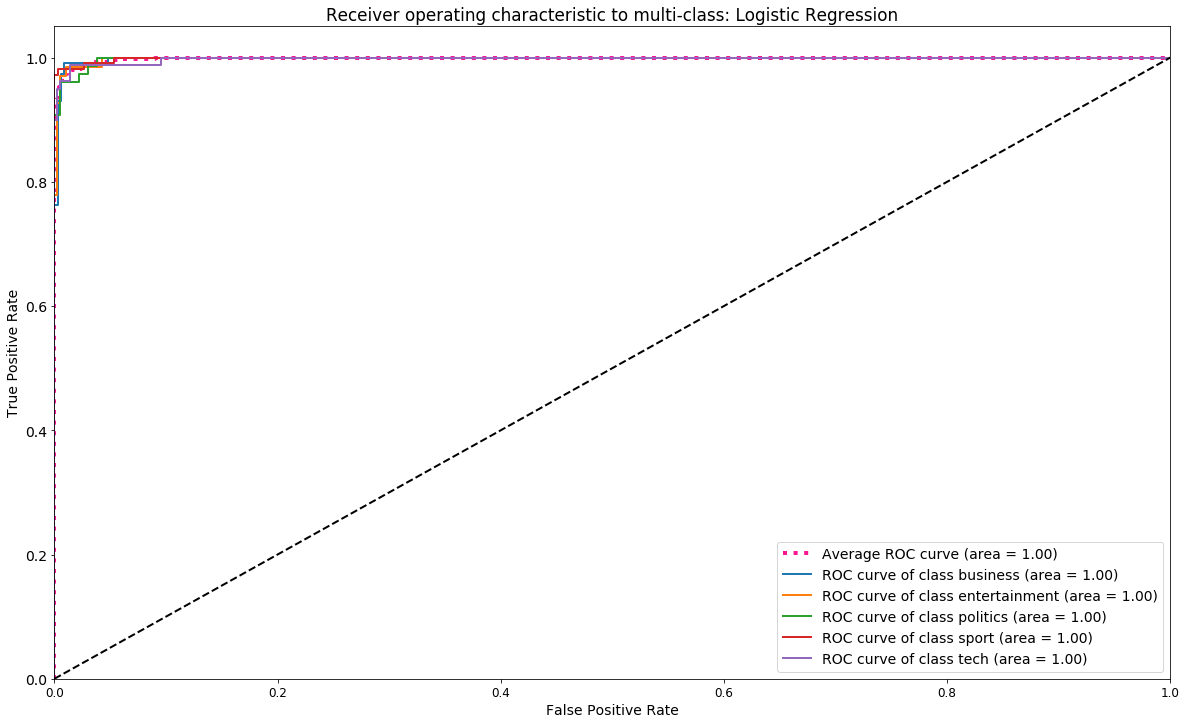

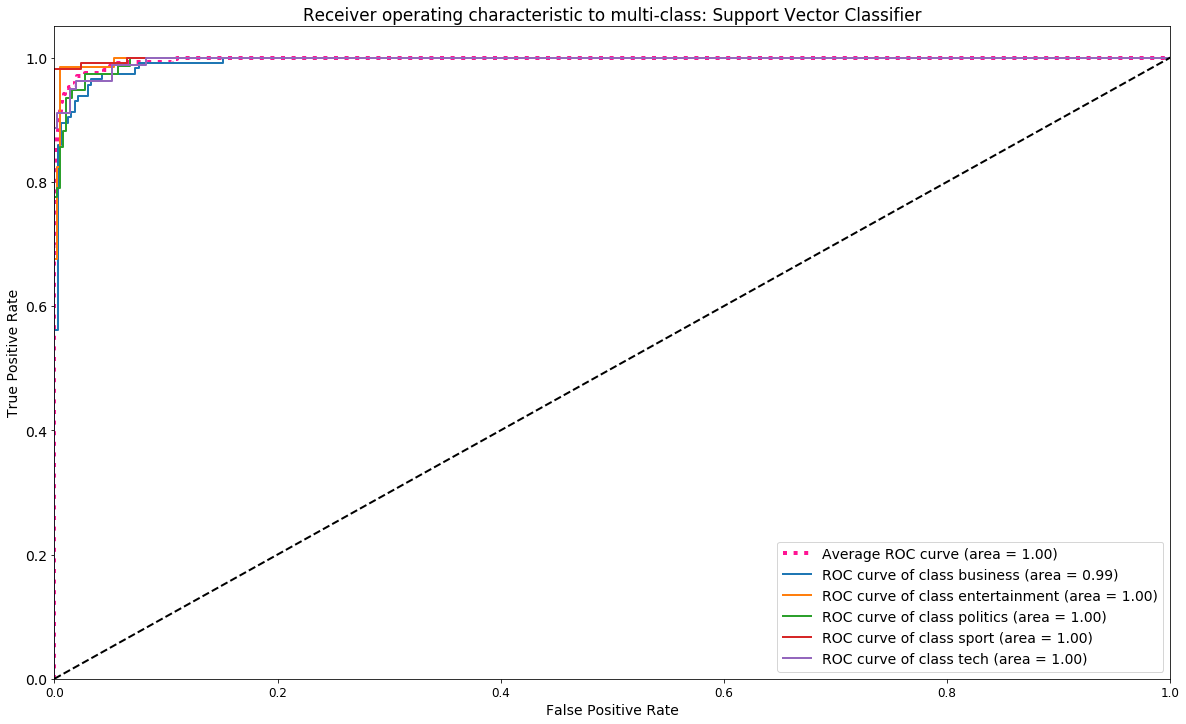

In [41]:
fn.roc_graph(clf_mlp_tf_idf, X_test, y_test, model_name = 'Multi-layer Perceptron', file_name='MLP')
fn.roc_graph(clf_xgb_tf_idf, X_test, y_test, model_name = 'XG Boost', file_name='xgboost')
fn.roc_graph(clf_rf_tf_idf, X_test, y_test, model_name = 'Random Forest', file_name='randomforest')
fn.roc_graph(clf_lr_tf_idf, X_test, y_test, model_name = 'Logistic Regression', file_name='logregression')
fn.roc_graph(clf_svc_tf_idf, X_test, y_test, model_name = 'Support Vector Classifier', file_name='svc')

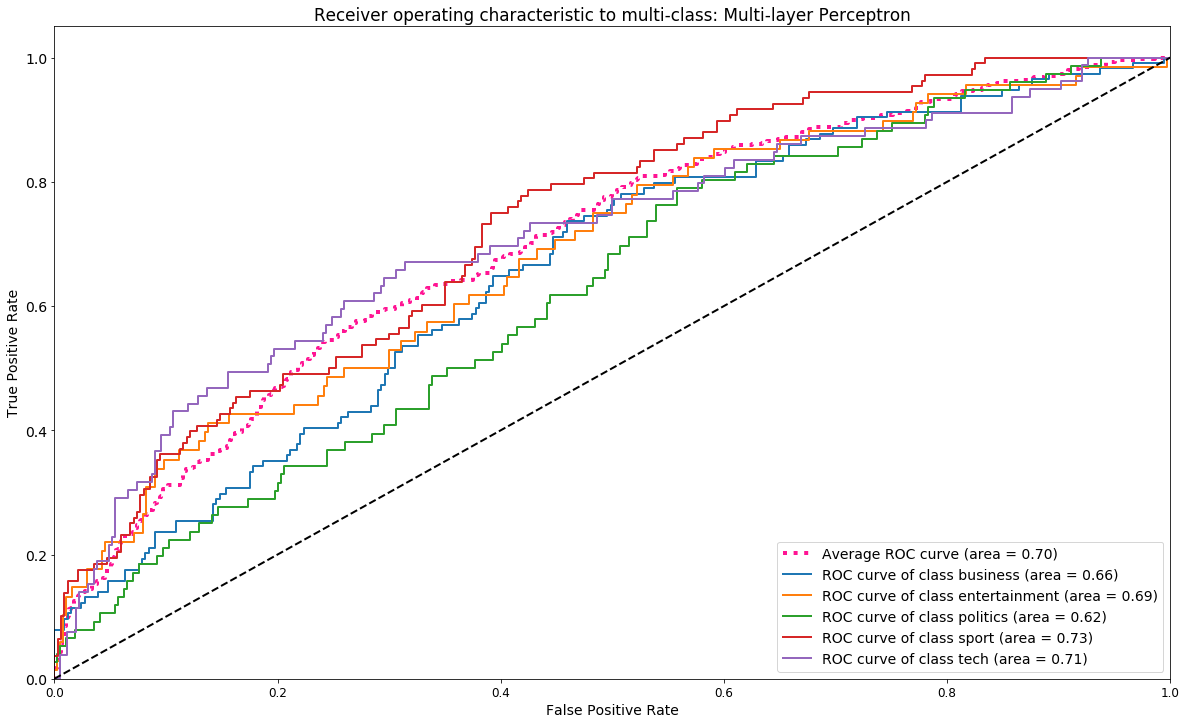

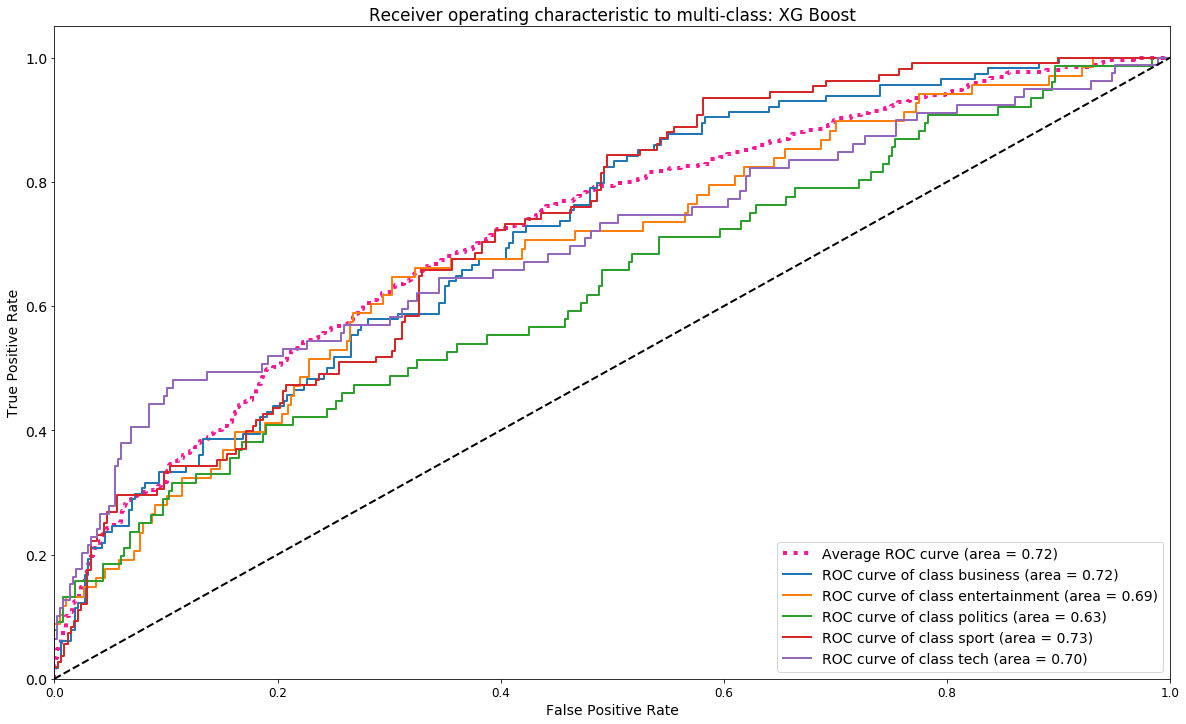

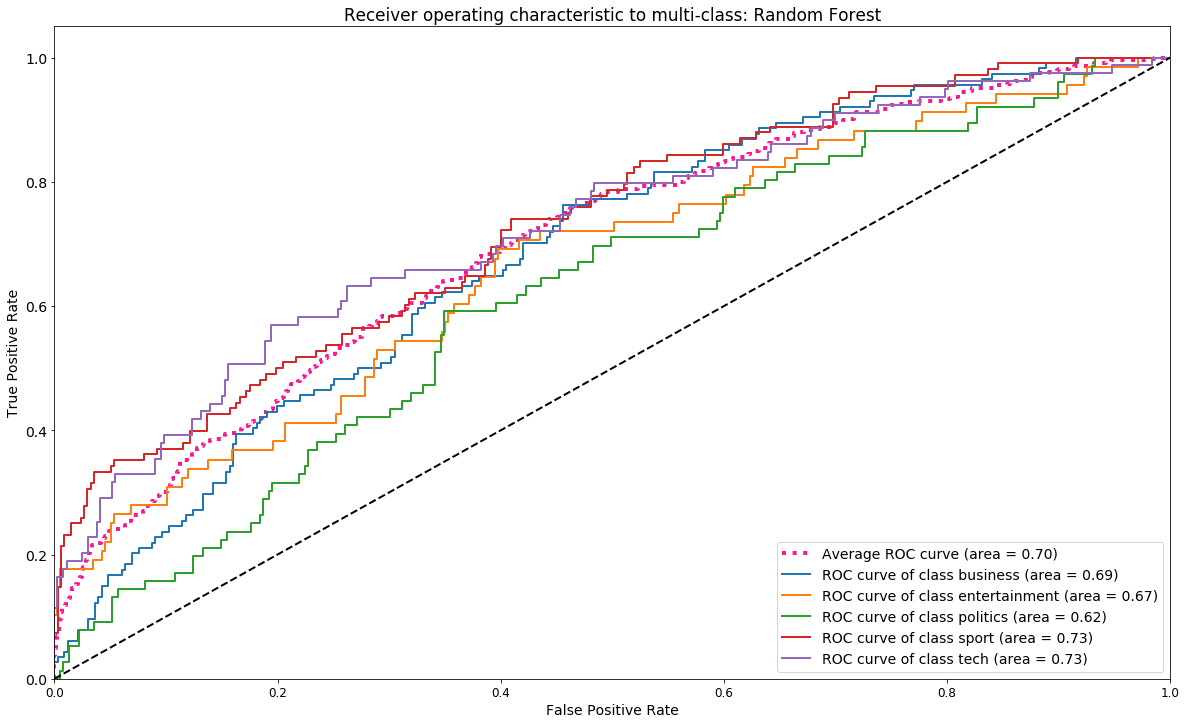

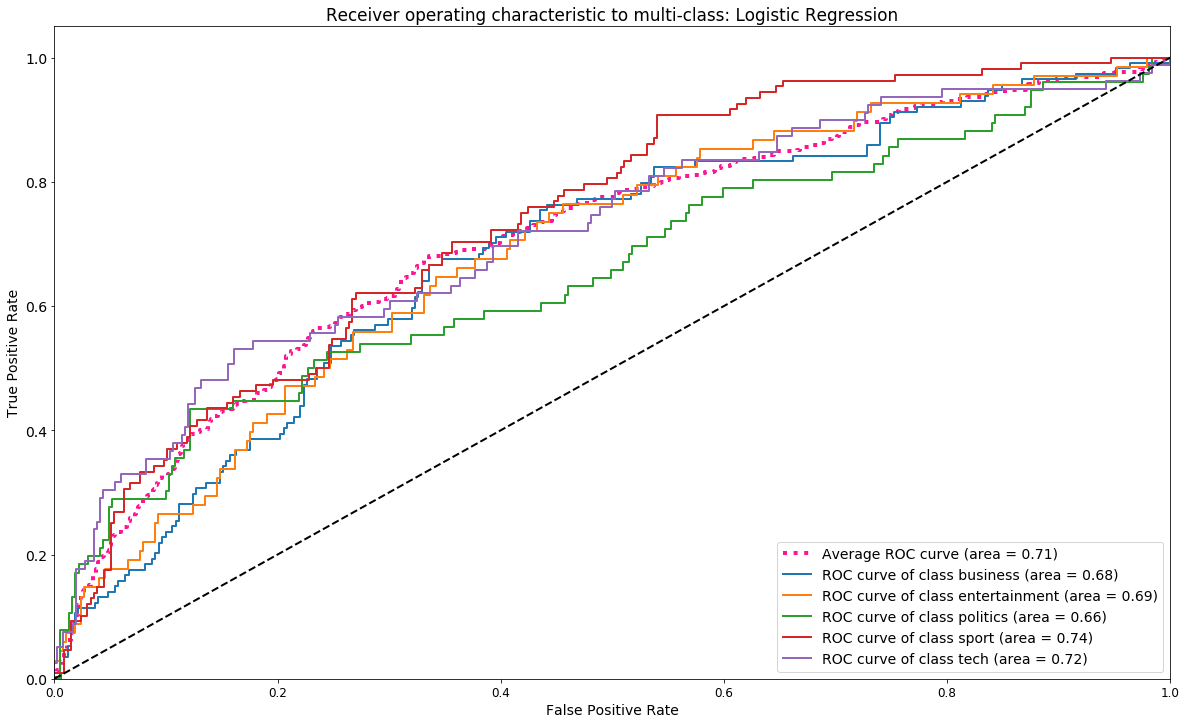

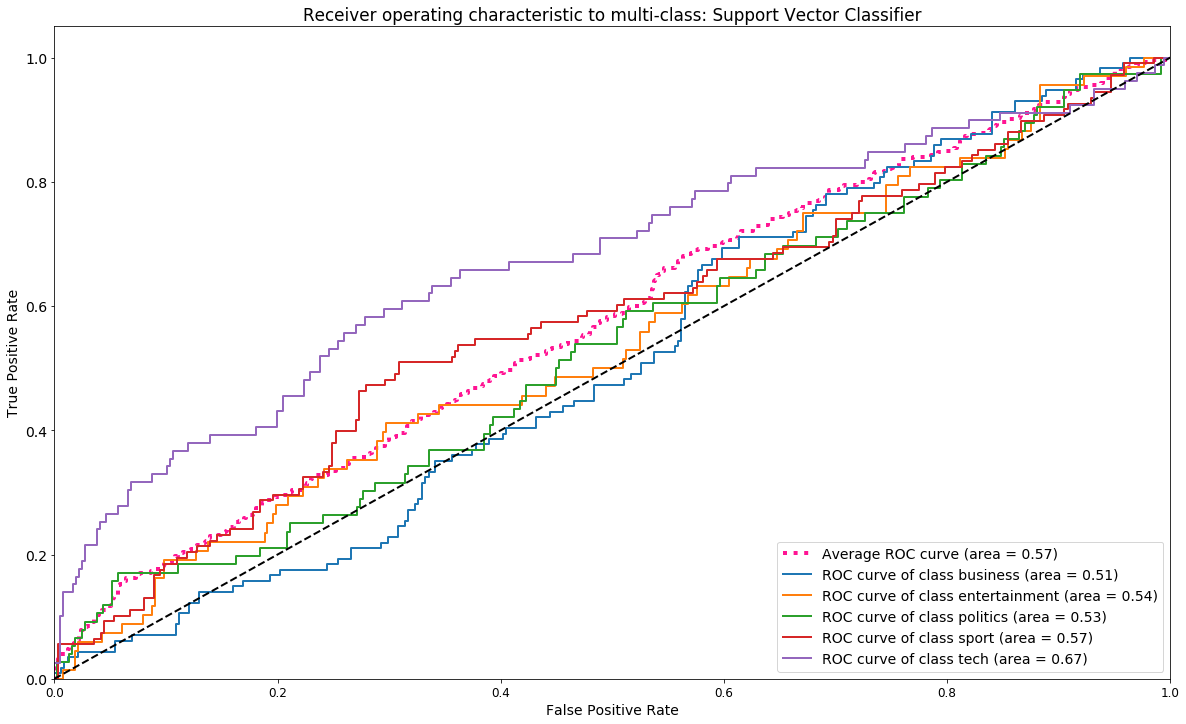

In [40]:
fn.roc_graph(clf_mlp, X_test, y_test, model_name = 'Multi-layer Perceptron', file_name='MLP_doc2vec')
fn.roc_graph(clf_xgb, X_test, y_test, model_name = 'XG Boost', file_name='xgboost_doc2vec')
fn.roc_graph(clf_rf, X_test, y_test, model_name = 'Random Forest', file_name='randomforest_doc2vec')
fn.roc_graph(clf_lr, X_test, y_test, model_name = 'Logistic Regression', file_name='logregression_doc2vec')
fn.roc_graph(clf_svc, X_test, y_test, model_name = 'Support Vector Classifier', file_name='svc_doc2vec')

In [282]:
modelos = { "DOC2VEC_RegLog": clf_lr, 
            "DOC2VEC_RandomForest": clf_rf, 
            "DOC2VEC_SVC":clf_svc,
            "DOC2VEC_MLP": clf_mlp,
            "DOC2VEC_XGBoost":clf_xgb,
            "TF-IDF_RegLog": clf_lr_tf_idf, 
            "TF-IDF_RandomForest": clf_rf_tf_idf, 
            "TF-IDF_SVC":clf_svc_tf_idf,
            "TF-IDF_MLP": clf_mlp_tf_idf,
            "TF-IDF_XGBoost":clf_xgb_tf_idf,             
}

In [283]:
tabela = fn.summary_stats(modelos, X_test, y_test, labels)
tabela

,Accuracy,Precision,Recall,F1-score,Jaccard score,False Positive Rate,False Negative Rate
DOC2VEC_RegLog,0.397753,0.445736,0.420225,0.377053,0.253773,0.152340,0.614979
DOC2VEC_RandomForest,0.417978,0.391278,0.408989,0.396365,0.275381,0.144433,0.578682
DOC2VEC_SVC,0.220225,0.293552,0.217978,0.181369,0.105062,0.199785,0.798155
DOC2VEC_MLP,0.413483,0.398435,0.388764,0.359551,0.214565,0.166356,0.662840
DOC2VEC_XGBoost,0.373034,0.432635,0.386517,0.380079,0.240335,0.144532,0.581771
TF-IDF_RegLog,0.966292,0.966685,0.966292,0.966235,0.934866,0.008503,0.036179
TF-IDF_RandomForest,0.955056,0.957511,0.955056,0.955299,0.914891,0.011677,0.047010
TF-IDF_SVC,0.955056,0.955351,0.955056,0.955055,0.914879,0.011247,0.043765
TF-IDF_MLP,0.979775,0.979829,0.979775,0.979711,0.960355,0.005087,0.022035
TF-IDF_XGBoost,0.948315,0.948853,0.948315,0.948443,0.903163,0.013255,0.052846


Confusion matrix: DOC2VEC_RegLog
[[0.65 0.05 0.11 0.13 0.06]
 [0.4  0.22 0.04 0.29 0.04]
 [0.51 0.03 0.18 0.24 0.04]
 [0.42 0.06 0.06 0.36 0.11]
 [0.39 0.04 0.13 0.13 0.32]]
Confusion matrix: DOC2VEC_RandomForest
[[0.48 0.06 0.14 0.21 0.11]
 [0.26 0.28 0.1  0.28 0.07]
 [0.29 0.12 0.26 0.21 0.12]
 [0.24 0.08 0.07 0.48 0.12]
 [0.24 0.04 0.09 0.18 0.46]]
Confusion matrix: DOC2VEC_SVC
[[0.1  0.07 0.   0.46 0.37]
 [0.1  0.1  0.   0.51 0.28]
 [0.13 0.12 0.01 0.38 0.36]
 [0.1  0.09 0.   0.51 0.3 ]
 [0.11 0.13 0.01 0.52 0.23]]
Confusion matrix: DOC2VEC_MLP
[[0.34 0.04 0.13 0.34 0.14]
 [0.12 0.19 0.12 0.49 0.09]
 [0.07 0.08 0.24 0.49 0.13]
 [0.11 0.08 0.06 0.68 0.07]
 [0.22 0.14 0.05 0.23 0.37]]
Confusion matrix: DOC2VEC_XGBoost
[[0.45 0.09 0.13 0.21 0.12]
 [0.24 0.25 0.1  0.37 0.04]
 [0.26 0.05 0.24 0.41 0.04]
 [0.19 0.08 0.06 0.56 0.1 ]
 [0.22 0.08 0.08 0.18 0.46]]
Confusion matrix: TF-IDF_RegLog
[[0.98 0.01 0.01 0.   0.  ]
 [0.01 0.97 0.   0.   0.01]
 [0.01 0.   0.96 0.03 0.  ]
 [0.01 0.01 0

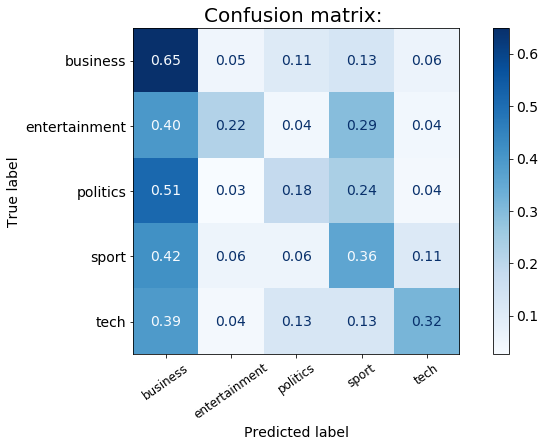

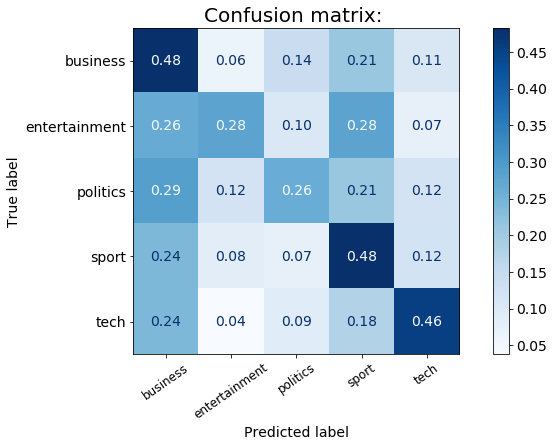

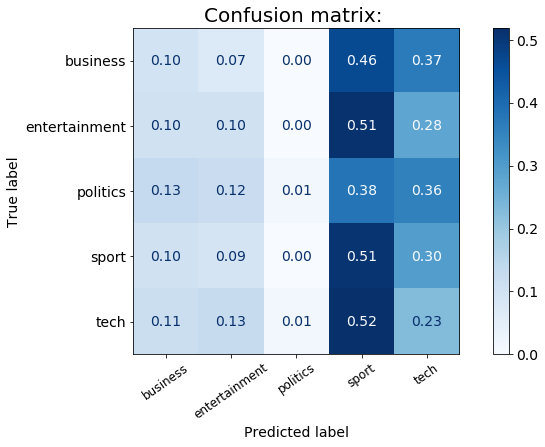

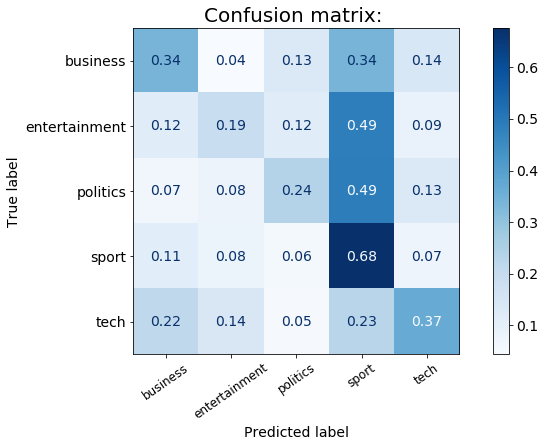

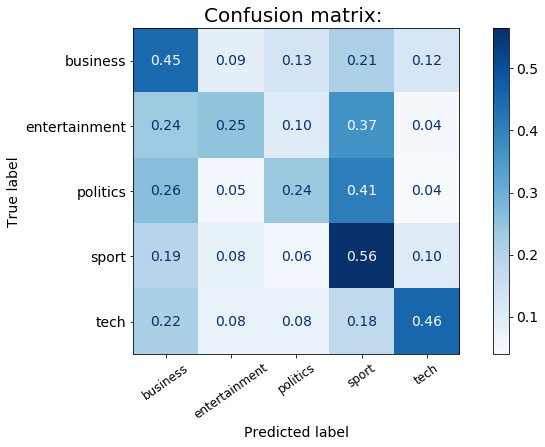

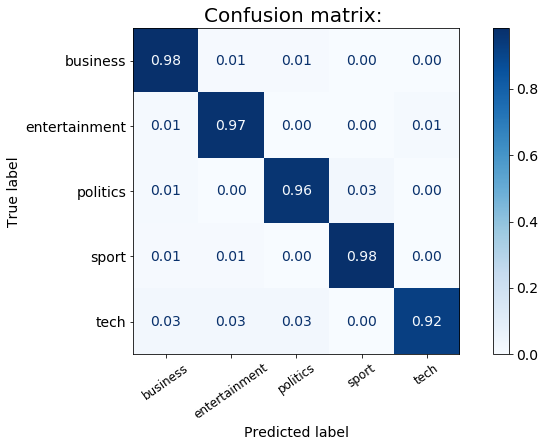

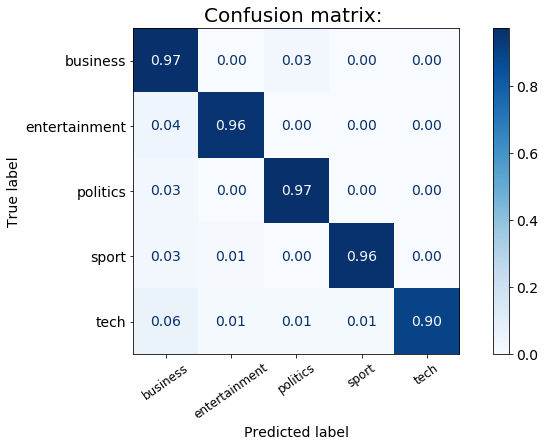

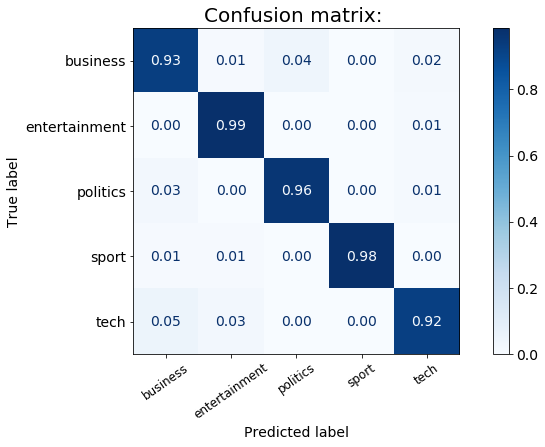

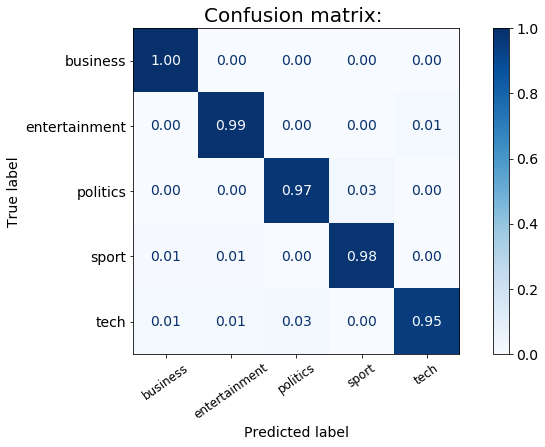

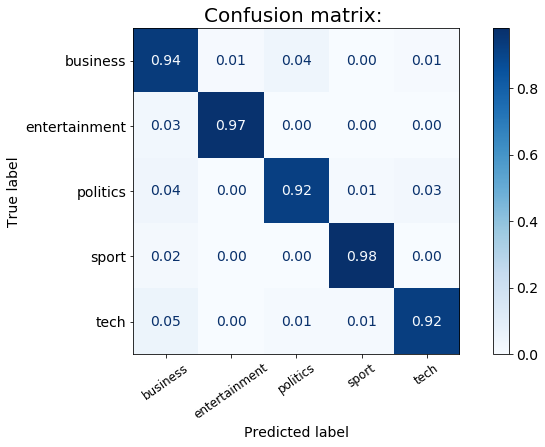

In [310]:
for modelo in modelos.items():
    fn.conf_matrix(modelo[1], X_test, y_test, labels, file_name=modelo[0])